# Notebook 02: Data Preprocessing

Systematic preprocessing of Ames Housing dataset based on exploratory findings to prepare clean data for machine learning model development.

## 1. Data Loading and Initial Processing

Load datasets and implement parser-guided missing data treatment strategies identified during exploratory analysis.

### 1.1 Dataset Import and Validation


In [74]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

print("Dataset Import Validation:")
print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")

# Create combined dataset for consistent feature processing
df_combined = pd.concat([
    df_train.drop('SalePrice', axis=1),
    df_test
], ignore_index=True)
df_combined['dataset_source'] = ['train']*len(df_train) + ['test']*len(df_test)

print(f"Combined dataset: {df_combined.shape}")
print(f"Features to process: {df_combined.shape[1] - 1}")

# Validate against Notebook 01 findings
expected_missing_features = 34
actual_missing_features = df_combined.drop('dataset_source', axis=1).isnull().any().sum()
print(f"\nMissing data validation:")
print(f"Expected features with missing data: {expected_missing_features}")
print(f"Actual features with missing data: {actual_missing_features}")
print(f"Validation: {'✓ PASS' if actual_missing_features == expected_missing_features else '✗ FAIL'}")

Dataset Import Validation:
Training data: (1460, 81)
Test data: (1459, 80)
Combined dataset: (2919, 81)
Features to process: 80

Missing data validation:
Expected features with missing data: 34
Actual features with missing data: 34
Validation: ✓ PASS


Dataset validation successful - all expected characteristics confirmed from Notebook 01 analysis.

### 1.2 Parser Integration Setup

In [75]:
# Setup data description parser for domain knowledge
from data_description_parser import (
    load_feature_descriptions,
    quick_feature_lookup,
    display_summary_table,
    get_categorical_features,
    get_numerical_features
)

# Load official documentation
feature_descriptions = load_feature_descriptions()
print("Parser Integration Setup:")
print("✓ Official real estate documentation loaded successfully")

# Get feature classifications for preprocessing
categorical_features = get_categorical_features(feature_descriptions)
numerical_features = get_numerical_features(feature_descriptions)

print(f"✓ Categorical features identified: {len(categorical_features)}")
print(f"✓ Numerical features identified: {len(numerical_features)}")

# Verify critical misclassified features from Notebook 01
misclassified_features = ['OverallQual', 'OverallCond', 'MSSubClass']
print(f"\nMisclassified ordinal features to correct:")
for feature in misclassified_features:
    feature_type = 'Categorical' if feature in categorical_features else 'Numerical'
    pandas_type = df_train[feature].dtype
    print(f"  {feature}: Parser={feature_type}, Pandas={pandas_type}")

Parser Integration Setup:
✓ Official real estate documentation loaded successfully
✓ Categorical features identified: 46
✓ Numerical features identified: 33

Misclassified ordinal features to correct:
  OverallQual: Parser=Categorical, Pandas=int64
  OverallCond: Parser=Categorical, Pandas=int64
  MSSubClass: Parser=Categorical, Pandas=int64


Parser integration confirmed 46 categorical and 33 numerical features with 3 misclassified ordinal features requiring correction.

## 2. Feature Classification Correction

Correct misclassified ordinal features identified in Notebook 01 before missing data treatment to ensure proper data types.

### 2.1 Ordinal Feature Correction

In [76]:
# Correct misclassified ordinal features identified in Notebook 01
ordinal_features = ['OverallQual', 'OverallCond', 'MSSubClass']

print("Ordinal Feature Correction:")
print("Converting integer-stored ordinal features to proper categorical types")

# Show current state before correction
print(f"\nBefore correction:")
for feature in ordinal_features:
    dtype = df_combined[feature].dtype
    unique_vals = sorted(df_combined[feature].unique())
    print(f"  {feature}: {dtype} with {len(unique_vals)} unique values: {unique_vals}")

# Convert to ordered categorical for combined dataset
print(f"\nApplying corrections:")
for feature in ordinal_features:
    if feature == 'MSSubClass':
        # MSSubClass: dwelling type categories
        print(f"  {feature}: Converting to unordered categorical (dwelling types)")
        df_combined[feature] = df_combined[feature].astype('category')
    else:
        # OverallQual and OverallCond: 1-10 quality scales
        print(f"  {feature}: Converting to ordered categorical (quality scale)")
        df_combined[feature] = pd.Categorical(df_combined[feature],
                                            categories=sorted(df_combined[feature].unique()),
                                            ordered=True)

print(f"\nAfter correction:")
for feature in ordinal_features:
    dtype = df_combined[feature].dtype
    is_ordered = hasattr(df_combined[feature], 'cat') and df_combined[feature].cat.ordered
    print(f"  {feature}: {dtype} (ordered: {is_ordered})")
    
    # Show categories for verification
    if hasattr(df_combined[feature], 'cat'):
        categories = list(df_combined[feature].cat.categories)
        print(f"    Categories: {categories}")

Ordinal Feature Correction:
Converting integer-stored ordinal features to proper categorical types

Before correction:
  OverallQual: int64 with 10 unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
  OverallCond: int64 with 9 unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  MSSubClass: int64 with 16 unique values: [np.int64(20), np.int64(30), np.int64(40), np.int64(45), np.int64(50), np.int64(60), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(120), np.int64(150), np.int64(160), np.int64(180), np.int64(190)]

Applying corrections:
  OverallQual: Converting to ordered categorical (quality scale)
  OverallCond: Converting to ordered categorical (quality scale)
  MSSubClass: Converting to unordered categorical (dwelling types)

After correction:
  OverallQual: category (ordered

Successfully converted 3 misclassified features to proper categorical types. OverallQual and OverallCond now preserve ordinal relationships (1-10 scales), while MSSubClass represents dwelling type categories.

## 3. Missing Data Treatment

Systematic analysis and treatment of 34 missing data features using parser consultation for domain-guided decisions.

### 3.1 Missing Data Analysis

In [77]:
# Get all features with missing data from combined dataset
missing_data = df_combined.drop('dataset_source', axis=1).isnull().sum()
missing_features = missing_data[missing_data > 0].sort_values(ascending=False)

print("Missing Data Overview:")
print(f"Total features with missing data: {len(missing_features)}")
print(f"Total missing values: {missing_features.sum()}")
print(f"Dataset completeness: {((len(df_combined) * 80 - missing_features.sum()) / (len(df_combined) * 80)) * 100:.1f}%")

print(f"\nTop 10 features with missing data:")
for feature, count in missing_features.head(10).items():
    pct = (count / len(df_combined)) * 100
    print(f"  {feature}: {count} missing ({pct:.1f}%)")

print(f"\nAll missing features for systematic treatment:")
for feature, count in missing_features.items():
    pct = (count / len(df_combined)) * 100
    print(f"  {feature}: {count} ({pct:.1f}%)")

Missing Data Overview:
Total features with missing data: 34
Total missing values: 15707
Dataset completeness: 93.3%

Top 10 features with missing data:
  PoolQC: 2909 missing (99.7%)
  MiscFeature: 2814 missing (96.4%)
  Alley: 2721 missing (93.2%)
  Fence: 2348 missing (80.4%)
  MasVnrType: 1766 missing (60.5%)
  FireplaceQu: 1420 missing (48.6%)
  LotFrontage: 486 missing (16.6%)
  GarageFinish: 159 missing (5.4%)
  GarageQual: 159 missing (5.4%)
  GarageCond: 159 missing (5.4%)

All missing features for systematic treatment:
  PoolQC: 2909 (99.7%)
  MiscFeature: 2814 (96.4%)
  Alley: 2721 (93.2%)
  Fence: 2348 (80.4%)
  MasVnrType: 1766 (60.5%)
  FireplaceQu: 1420 (48.6%)
  LotFrontage: 486 (16.6%)
  GarageFinish: 159 (5.4%)
  GarageQual: 159 (5.4%)
  GarageCond: 159 (5.4%)
  GarageYrBlt: 159 (5.4%)
  GarageType: 157 (5.4%)
  BsmtExposure: 82 (2.8%)
  BsmtCond: 82 (2.8%)
  BsmtQual: 81 (2.8%)
  BsmtFinType2: 80 (2.7%)
  BsmtFinType1: 79 (2.7%)
  MasVnrArea: 23 (0.8%)
  MSZoning: 4 (

Confirmed 34 features with 15,707 missing values across combined dataset. Clear patterns emerge: high-impact amenity features (>50% missing) and coordinated feature groups (garage ~5.4%, basement ~2.8%) indicating systematic architectural absence.

### 3.2 Parser-Guided Feature Analysis

In [78]:
# Parser consultation for missing features - discovery phase
print(f"\nSystematic Parser Consultation for Missing Features:")
print("="*70)

# Get all features with missing data 
all_missing_features = missing_features.index.tolist()  # From section 3.1
print(f"Total features to analyze: {len(all_missing_features)}")

# Process each feature individually
for i, feature in enumerate(all_missing_features, 1):
    missing_count = df_combined[feature].isnull().sum()
    missing_pct = (missing_count / len(df_combined)) * 100
    
    print(f"\n{i}. {feature}")
    print("-" * 50)
    print(f"Missing: {missing_count} values ({missing_pct:.1f}%)")
    
    # Parser consultation
    quick_feature_lookup(feature, feature_descriptions)
    
    # Show feature context and distribution
    if df_combined[feature].dtype == 'object':
        # Categorical feature
        unique_values = df_combined[feature].dropna().unique()
        print(f"Data type: Categorical ({len(unique_values)} unique values)")
        
        # Value distribution 
        value_counts = df_combined[feature].value_counts()
        print(f"Value distribution:")
        for value, count in value_counts.items():
            pct = (count / value_counts.sum()) * 100
            print(f"  {value}: {count} ({pct:.1f}%)")
    else:
        # Numerical feature  
        train_mask = df_combined['dataset_source'] == 'train'
        train_data = df_combined[train_mask][feature].dropna()
        print(f"Data type: Numerical")
        print(f"Range: {train_data.min():.1f} - {train_data.max():.1f}")
        print(f"Stats: Mean={train_data.mean():.1f}, Median={train_data.median():.1f}")
        
        # Check for zero values
        zero_count = (train_data == 0).sum()
        if zero_count > 0:
            zero_pct = (zero_count / len(train_data)) * 100
            print(f"Zero values: {zero_count} ({zero_pct:.1f}%)")
    

print(f"\n✓ Parser consultation completed for all {len(all_missing_features)} features")


Systematic Parser Consultation for Missing Features:
Total features to analyze: 34

1. PoolQC
--------------------------------------------------
Missing: 2909 values (99.7%)
Feature: PoolQC
Description: Pool quality
Type: Categorical

Categories:
  Ex: Excellent
  Gd: Good
  TA: Average/Typical
  Fa: Fair
  NA: No Pool
------------------------------------------------------------
Data type: Categorical (3 unique values)
Value distribution:
  Ex: 4 (40.0%)
  Gd: 4 (40.0%)
  Fa: 2 (20.0%)

2. MiscFeature
--------------------------------------------------
Missing: 2814 values (96.4%)
Feature: MiscFeature
Description: Miscellaneous feature not covered in other categories
Type: Categorical

Categories:
  Elev: Elevator
  Gar2: 2nd Garage (if not described in garage section)
  Othr: Other
  Shed: Shed (over 100 SF)
  TenC: Tennis Court
  NA: None
------------------------------------------------------------
Data type: Categorical (4 unique values)
Value distribution:
  Shed: 95 (90.5%)
  Gar2

Based on parser consultation, categorize features into treatment strategies.

### 3.3 Features Known to be Zero (Complete Structural Absence)

In [79]:
# GROUP 1: Amenity/Optional Structure Features - Missing = Structure Doesn't Exist
amenity_none_features = [
    'PoolQC',        # 99.7% missing - most houses don't have pools
    'MiscFeature',   # 96.4% missing - most houses don't have elevators/tennis courts
    'Alley',         # 93.2% missing - most houses don't have alley access
    'Fence',         # 80.4% missing - many houses don't have fences
    'FireplaceQu'    # 48.6% missing - many houses don't have fireplaces
]

# GROUP 2: Coordinated Structure Features - Missing = No Garage/Basement Exists
garage_none_features = [
    'GarageFinish',  # 5.4% missing - no garage = no finish to evaluate
    'GarageQual',    # 5.4% missing - no garage = no quality to rate
    'GarageCond',    # 5.4% missing - no garage = no condition to assess
    'GarageType'     # 5.4% missing - no garage = no type to classify
]

basement_none_features = [
    'BsmtExposure',  # 2.8% missing - no basement = no exposure to evaluate
    'BsmtCond',      # 2.8% missing - no basement = no condition to assess
    'BsmtQual',      # 2.8% missing - no basement = no quality to rate
    'BsmtFinType2',  # 2.7% missing - no basement = no finished area types
    'BsmtFinType1'   # 2.7% missing - no basement = no finished area types
]

# GROUP 3: Masonry Special Case - Has explicit "None" category
masonry_none_features = ['MasVnrType']  # Has "None: None" category for houses without masonry

# Combine all "None" replacement features
all_none_features = amenity_none_features + garage_none_features + basement_none_features + masonry_none_features

print(f"Applying 'None' replacement for {len(all_none_features)} categorical features:")

# Apply "None" replacement for structural absence
for feature in all_none_features:
    before_missing = df_combined[feature].isnull().sum()
    df_combined[feature] = df_combined[feature].fillna('None')
    print(f"✓ {feature}: {before_missing} missing → 'None'")

print(f"\n✓ Completed 'None' replacement for absent structures")

Applying 'None' replacement for 15 categorical features:
✓ PoolQC: 2909 missing → 'None'
✓ MiscFeature: 2814 missing → 'None'
✓ Alley: 2721 missing → 'None'
✓ Fence: 2348 missing → 'None'
✓ FireplaceQu: 1420 missing → 'None'
✓ GarageFinish: 159 missing → 'None'
✓ GarageQual: 159 missing → 'None'
✓ GarageCond: 159 missing → 'None'
✓ GarageType: 157 missing → 'None'
✓ BsmtExposure: 82 missing → 'None'
✓ BsmtCond: 82 missing → 'None'
✓ BsmtQual: 81 missing → 'None'
✓ BsmtFinType2: 80 missing → 'None'
✓ BsmtFinType1: 79 missing → 'None'
✓ MasVnrType: 1766 missing → 'None'

✓ Completed 'None' replacement for absent structures


Applied 'None' replacement to 15 categorical features representing absent structures (pools, garages, basements, amenities).
### 3.4: Geographic Features (Neighborhood-Based Treatment)

In [80]:
# Geographic numerical features - use neighborhood context
geographic_numerical = ['LotFrontage']  # Street frontage varies by neighborhood development patterns

# Geographic categorical features - use neighborhood mode
geographic_categorical = {
    'MSZoning': 'zoning clusters geographically',
    'Exterior1st': 'architectural styles cluster',
    'Exterior2nd': 'architectural styles cluster', 
    'SaleType': 'construction patterns vary by area'
}

# System/standard categorical features - also use neighborhood mode
system_categorical = {
    'Electrical': 'electrical standards may vary by neighborhood development era',
    'Utilities': 'utility access patterns cluster geographically',
    'Functional': 'functionality standards cluster by neighborhood',
    'KitchenQual': 'kitchen quality varies by neighborhood characteristics'
}

# Process geographic numerical features
print("Geographic numerical features:")
for feature in geographic_numerical:
    if df_combined[feature].isnull().sum() > 0:
        missing_count = df_combined[feature].isnull().sum()
        df_combined[feature] = df_combined.groupby('Neighborhood')[feature].transform(
            lambda x: x.fillna(x.median())
        )
        print(f"✓ {feature}: {missing_count} missing → neighborhood median")

# Process all categorical features with neighborhood mode
all_categorical = {**geographic_categorical, **system_categorical}

print(f"\nCategorical features (neighborhood mode):")
for feature, reason in all_categorical.items():
    if df_combined[feature].isnull().sum() > 0:
        missing_count = df_combined[feature].isnull().sum()
        
        # Calculate neighborhood mode
        neighborhood_mode = df_combined.groupby('Neighborhood')[feature].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )
        
        # Fill missing values with neighborhood mode
        for neighborhood in df_combined['Neighborhood'].unique():
            if neighborhood in neighborhood_mode.index and pd.notna(neighborhood_mode[neighborhood]):
                mask = (df_combined['Neighborhood'] == neighborhood) & df_combined[feature].isnull()
                df_combined.loc[mask, feature] = neighborhood_mode[neighborhood]
        
        # Fallback: use overall mode for any remaining missing values
        if df_combined[feature].isnull().sum() > 0:
            overall_mode = df_combined[feature].mode()[0]
            df_combined[feature].fillna(overall_mode, inplace=True)
        
        print(f"✓ {feature}: {missing_count} missing → neighborhood mode ({reason})")

print(f"\n✓ Completed neighborhood-based treatment for geographic features")

Geographic numerical features:
✓ LotFrontage: 486 missing → neighborhood median

Categorical features (neighborhood mode):
✓ MSZoning: 4 missing → neighborhood mode (zoning clusters geographically)
✓ Exterior1st: 1 missing → neighborhood mode (architectural styles cluster)
✓ Exterior2nd: 1 missing → neighborhood mode (architectural styles cluster)
✓ SaleType: 1 missing → neighborhood mode (construction patterns vary by area)
✓ Electrical: 1 missing → neighborhood mode (electrical standards may vary by neighborhood development era)
✓ Utilities: 2 missing → neighborhood mode (utility access patterns cluster geographically)
✓ Functional: 2 missing → neighborhood mode (functionality standards cluster by neighborhood)
✓ KitchenQual: 1 missing → neighborhood mode (kitchen quality varies by neighborhood characteristics)

✓ Completed neighborhood-based treatment for geographic features


Geographic and system features treated using neighborhood mode for 9 categorical and 1 numerical feature.

### 3.5 Coordinated Numerical Features (Manual Review Required)

In [81]:
# Define coordinated numerical features that should be analyzed together
coordinated_features = {
    'GarageYrBlt': 'garage construction year',
    'GarageArea': 'garage square footage',
    'GarageCars': 'garage capacity',
    'TotalBsmtSF': 'basement total square footage',
    'BsmtUnfSF': 'basement unfinished square footage',
    'BsmtFinSF1': 'basement finished area 1',
    'BsmtFinSF2': 'basement finished area 2',
    'BsmtFullBath': 'basement full bathrooms',
    'BsmtHalfBath': 'basement half bathrooms',
    'MasVnrArea': 'masonry veneer area'
}

# Special handling for GarageYrBlt (coordinate with house construction)
if 'GarageYrBlt' in coordinated_features and df_combined['GarageYrBlt'].isnull().sum() > 0:
    missing_count = df_combined['GarageYrBlt'].isnull().sum()
    print(f"\nGarageYrBlt analysis:")
    print(f"Missing values: {missing_count}")

    # Check coordination with GarageType
    garage_exists_mask = df_combined['GarageType'] != 'None'
    garage_missing_mask = df_combined['GarageYrBlt'].isnull()

    # Set to 0 for houses without garages
    no_garage_missing_year = ~garage_exists_mask & garage_missing_mask
    has_garage_but_missing_year = garage_exists_mask & garage_missing_mask

    if no_garage_missing_year.sum() > 0:
        df_combined.loc[no_garage_missing_year, 'GarageYrBlt'] = 0
        print(f"✓ Set {no_garage_missing_year.sum()} houses without garages to 0")

    if has_garage_but_missing_year.sum() > 0:
        missing_house_ids = df_combined[has_garage_but_missing_year]['Id'].tolist()
        print(f"→ {has_garage_but_missing_year.sum()} houses with garages missing GarageYrBlt")
        print(f"  House IDs requiring manual review: {missing_house_ids}")

# Analyze remaining coordinated features
remaining_features = {k: v for k, v in coordinated_features.items() if k != 'GarageYrBlt'}

print(f"\nAnalyzing {len(remaining_features)} coordinated numerical features:")

for feature, description in remaining_features.items():
    missing_count = df_combined[feature].isnull().sum()
    total_count = len(df_combined)
    missing_pct = (missing_count / total_count) * 100

    print(f"\n{feature} ({description}):")
    print(f"  Missing: {missing_count}/{total_count} ({missing_pct:.1f}%)")

    if missing_count == 0:
        print(f"  ✓ No missing values")
    elif missing_count == total_count:
        print(f"  → ALL missing - setting to 0 (structure doesn't exist)")
        df_combined[feature] = 0
    else:
        # Handle coordinated features with structure existence logic
        if 'Garage' in feature:
            # Check garage existence
            structure_exists_mask = df_combined['GarageType'] != 'None'
            missing_mask = df_combined[feature].isnull()

            # Set to 0 for houses without garages
            no_structure = ~structure_exists_mask & missing_mask
            has_structure_missing = structure_exists_mask & missing_mask

            if no_structure.sum() > 0:
                df_combined.loc[no_structure, feature] = 0
                print(f"  ✓ Set {no_structure.sum()} houses without garage to 0")

            if has_structure_missing.sum() > 0:
                missing_house_ids = df_combined[has_structure_missing]['Id'].tolist()
                print(f"  → {has_structure_missing.sum()} houses with garages missing {feature}")
                print(f"  House IDs requiring manual review: {missing_house_ids}")

        elif 'Bsmt' in feature:
            # Check basement existence
            structure_exists_mask = df_combined['BsmtQual'] != 'None'
            missing_mask = df_combined[feature].isnull()

            # Set to 0 for houses without basements
            no_structure = ~structure_exists_mask & missing_mask
            has_structure_missing = structure_exists_mask & missing_mask

            if no_structure.sum() > 0:
                df_combined.loc[no_structure, feature] = 0
                print(f"  ✓ Set {no_structure.sum()} houses without basement to 0")

            if has_structure_missing.sum() > 0:
                missing_house_ids = df_combined[has_structure_missing]['Id'].tolist()
                print(f"  → {has_structure_missing.sum()} houses with basements missing {feature}")
                print(f"  House IDs requiring manual review: {missing_house_ids}")

        elif 'MasVnr' in feature:
            # Check masonry existence
            structure_exists_mask = df_combined['MasVnrType'] != 'None'
            missing_mask = df_combined[feature].isnull()

            # Set to 0 for houses without masonry
            no_structure = ~structure_exists_mask & missing_mask
            has_structure_missing = structure_exists_mask & missing_mask

            if no_structure.sum() > 0:
                df_combined.loc[no_structure, feature] = 0
                print(f"  ✓ Set {no_structure.sum()} houses without masonry to 0")

            if has_structure_missing.sum() > 0:
                missing_house_ids = df_combined[has_structure_missing]['Id'].tolist()
                print(f"  → {has_structure_missing.sum()} houses with masonry missing {feature}")
                print(f"  House IDs requiring manual review: {missing_house_ids}")
        else:
            # Fallback for other features
            missing_mask = df_combined[feature].isnull()
            missing_house_ids = df_combined[missing_mask]['Id'].tolist()
            print(f"  → PARTIAL missing - requires manual review")
            print(f"  House IDs with missing {feature}: {missing_house_ids}")

print(f"\n  Manual review required for features with partial missing values")
print(f"   Review house IDs above and decide treatment strategy")


GarageYrBlt analysis:
Missing values: 159
✓ Set 157 houses without garages to 0
→ 2 houses with garages missing GarageYrBlt
  House IDs requiring manual review: [2127, 2577]

Analyzing 9 coordinated numerical features:

GarageArea (garage square footage):
  Missing: 1/2919 (0.0%)
  → 1 houses with garages missing GarageArea
  House IDs requiring manual review: [2577]

GarageCars (garage capacity):
  Missing: 1/2919 (0.0%)
  → 1 houses with garages missing GarageCars
  House IDs requiring manual review: [2577]

TotalBsmtSF (basement total square footage):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtUnfSF (basement unfinished square footage):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtFinSF1 (basement finished area 1):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtFinSF2 (basement finished area 2):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtFullBath (basement full bathrooms):
  Missing: 2

Coordinated feature analysis identified 2 houses requiring manual review for garage timing and measurement features.

### 3.6 Manual Review Analysis for Missing Coordinated Features

In [82]:
# Houses requiring manual review 
garage_timing_missing = [2127, 2577]  # Missing GarageYrBlt
garage_measurement_missing = [2577]   # Missing GarageArea, GarageCars

# Analyze each house's characteristics
review_houses = list(set(garage_timing_missing + garage_measurement_missing))

for house_id in review_houses:
    print(f"\n--- House ID {house_id} Analysis ---")

    # Get house data using ID lookup
    house_data = df_combined[df_combined['Id'] == house_id].iloc[0]

    # Garage features
    garage_features = ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt', 'GarageArea', 'GarageCars']
    print("Garage features:")
    for feature in garage_features:
        if feature in df_combined.columns:
            value = house_data[feature]
            is_missing = pd.isna(value)
            print(f"  {feature}: {value} {'(MISSING)' if is_missing else ''}")

    # House construction timing
    timing_features = ['YearBuilt', 'YearRemodAdd']
    print("Construction timing:")
    for feature in timing_features:
        if feature in df_combined.columns:
            value = house_data[feature]
            print(f"  {feature}: {value}")

    # Additional context
    context_features = ['OverallQual', 'OverallCond', 'Neighborhood']
    print("Additional context:")
    for feature in context_features:
        if feature in df_combined.columns:
            value = house_data[feature]
            print(f"  {feature}: {value}")



--- House ID 2577 Analysis ---
Garage features:
  GarageType: Detchd 
  GarageQual: None 
  GarageCond: None 
  GarageFinish: None 
  GarageYrBlt: nan (MISSING)
  GarageArea: nan (MISSING)
  GarageCars: nan (MISSING)
Construction timing:
  YearBuilt: 1923
  YearRemodAdd: 1999
Additional context:
  OverallQual: 5
  OverallCond: 6
  Neighborhood: IDOTRR

--- House ID 2127 Analysis ---
Garage features:
  GarageType: Detchd 
  GarageQual: None 
  GarageCond: None 
  GarageFinish: None 
  GarageYrBlt: nan (MISSING)
  GarageArea: 360.0 
  GarageCars: 1.0 
Construction timing:
  YearBuilt: 1910
  YearRemodAdd: 1983
Additional context:
  OverallQual: 6
  OverallCond: 8
  Neighborhood: OldTown


Analysis identified 2 houses requiring individual assessment for garage feature consistency and data quality decisions.

### 3.7 Manual Decision Implementation

In [83]:
# House 2127: Garage exists with measurements, only missing year
print("House 2127: Setting GarageYrBlt to YearRemodAdd (1983)")
house_2127_idx = df_combined[df_combined['Id'] == 2127].index[0]
df_combined.loc[house_2127_idx, 'GarageYrBlt'] = df_combined.loc[house_2127_idx, 'YearRemodAdd']

# House 2577: All garage features missing/None, treat as no functional garage
print("House 2577: Setting all garage features to None/0 (no functional garage)")
house_2577_idx = df_combined[df_combined['Id'] == 2577].index[0]
df_combined.loc[house_2577_idx, 'GarageType'] = 'None'
df_combined.loc[house_2577_idx, 'GarageYrBlt'] = 0
df_combined.loc[house_2577_idx, 'GarageArea'] = 0
df_combined.loc[house_2577_idx, 'GarageCars'] = 0

# Validate changes
print(f"\nValidation:")
for house_id in [2127, 2577]:
    house_idx = df_combined[df_combined['Id'] == house_id].index[0]
    garage_features = ['GarageType', 'GarageYrBlt', 'GarageArea', 'GarageCars']
    values = [df_combined.loc[house_idx, feature] for feature in garage_features]
    print(f"House {house_id}: {dict(zip(garage_features, values))}")

# Final missing data check for coordinated features
coordinated_features = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF',
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

remaining_missing = df_combined[coordinated_features].isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

print(f"\nRemaining missing values in coordinated features:")
if len(remaining_missing) == 0:
    print("✓ No missing values remaining")
else:
    for feature, count in remaining_missing.items():
        print(f"  {feature}: {count}")

House 2127: Setting GarageYrBlt to YearRemodAdd (1983)
House 2577: Setting all garage features to None/0 (no functional garage)

Validation:
House 2127: {'GarageType': 'Detchd', 'GarageYrBlt': np.float64(1983.0), 'GarageArea': np.float64(360.0), 'GarageCars': np.float64(1.0)}
House 2577: {'GarageType': 'None', 'GarageYrBlt': np.float64(0.0), 'GarageArea': np.float64(0.0), 'GarageCars': np.float64(0.0)}

Remaining missing values in coordinated features:
✓ No missing values remaining


Manual decisions applied: House 2127 garage timing corrected, House 2577 treated as no functional garage for data consistency.

### 3.8 Final Missing Data Validation

In [84]:
# Final comprehensive missing data check
print("=== FINAL MISSING DATA VALIDATION ===")

# Check all features for remaining missing values
all_missing = df_combined.drop('dataset_source', axis=1).isnull().sum()
remaining_missing = all_missing[all_missing > 0].sort_values(ascending=False)

print(f"Missing data summary:")
print(f"Total features: {len(all_missing)}")
print(f"Features with missing values: {len(remaining_missing)}")
print(f"Total missing values: {remaining_missing.sum()}")

if len(remaining_missing) == 0:
    print("✓ SUCCESS: No missing values remaining in dataset")
else:
    print(f"\n⚠️ Remaining missing values:")
    for feature, count in remaining_missing.items():
        pct = (count / len(df_combined)) * 100
        print(f"  {feature}: {count} ({pct:.2f}%)")

# Validate specific coordinated features are clean
coordinated_check = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF',
                    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

coordinated_missing = df_combined[coordinated_check].isnull().sum()
coordinated_remaining = coordinated_missing[coordinated_missing > 0]

print(f"\nCoordinated features validation:")
if len(coordinated_remaining) == 0:
    print("✓ All coordinated numerical features complete")
else:
    print("Issues with coordinated features:")
    for feature, count in coordinated_remaining.items():
        print(f"  {feature}: {count} missing")

=== FINAL MISSING DATA VALIDATION ===
Missing data summary:
Total features: 80
Features with missing values: 0
Total missing values: 0
✓ SUCCESS: No missing values remaining in dataset

Coordinated features validation:
✓ All coordinated numerical features complete


Missing data treatment completed for 34 features using structure-aware logic, achieving zero missing values with coordinated feature consistency.

## 4. Categorical Feature Encoding

Manual integer mapping for ordinal features and one-hot encoding for nominal features to ensure optimal ML algorithm compatibility.

### 4.1 Ordinal Encoding

In [85]:
# Standard quality/condition features with consistent 5-point scale
ordinal_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for feature in ordinal_1:
    if feature in df_combined.columns:
        if 'None' in df_combined[feature].values:
            mapping = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
            df_combined[feature] = df_combined[feature].map(mapping).astype('int')
            print(f"✓ {feature}: {mapping}")
        else:
            mapping = {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
            df_combined[feature] = df_combined[feature].map(mapping).astype('int')
            print(f"✓ {feature}: {mapping}")

# Individual ordinal features with custom mappings
ordinal_2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Fence']

# Apply custom mappings and print actual mappings
exposure_map = {"None":0, "No":1,"Mn":2,"Av":3,"Gd":4}
fintype_map = {"None":0, "Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}
finish_map = {"None":0,"Unf":1,"RFn":2,"Fin":3}
fence_map = {"None":0, "MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4}

df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map(exposure_map).astype('int')
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map(fintype_map).astype('int')
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map(fintype_map).astype('int')
df_combined['GarageFinish'] = df_combined['GarageFinish'].map(finish_map).astype('int')
df_combined['Fence'] = df_combined['Fence'].map(fence_map).astype('int')

print(f"✓ BsmtExposure: {exposure_map}")
print(f"✓ BsmtFinType1: {fintype_map}")
print(f"✓ BsmtFinType2: {fintype_map}")
print(f"✓ GarageFinish: {finish_map}")
print(f"✓ Fence: {fence_map}")

# Get list of all encoded ordinal features
ordinal_encoded_features = ordinal_1 + ordinal_2
print(f"\n✓ Total ordinal features encoded: {len(ordinal_encoded_features)}")

✓ ExterQual: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ ExterCond: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ BsmtQual: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ BsmtCond: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ HeatingQC: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ KitchenQual: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ FireplaceQu: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ GarageQual: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ GarageCond: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ PoolQC: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ BsmtExposure: {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
✓ BsmtFinType1: {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
✓ BsmtFinType2: {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
✓ GarageFinish: {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
✓ Fence: {'None': 0, 'MnWw': 1, 'GdWo': 2, 'M

### 4.2 One-Hot Encoding

In [86]:
# Get remaining categorical features for one-hot encoding
categorical_features = df_combined.select_dtypes(include='object').columns.tolist()

# Remove ordinal features and special cases
nominal_features = [f for f in categorical_features
                   if f not in ordinal_encoded_features
                   and f not in ['OverallQual', 'OverallCond', 'MSSubClass', 'dataset_source']]

print(f"One-Hot Encoding for {len(nominal_features)} nominal features:")
for feature in nominal_features:
    categories = sorted(df_combined[feature].unique())
    print(f"  {feature}: {categories}")

# Apply one-hot encoding with drop_first to prevent multicollinearity
if len(nominal_features) > 0:
    # Create one-hot encoded features
    df_encoded = pd.get_dummies(df_combined[nominal_features], drop_first=True, dtype=int)

    # Drop original categorical columns and add encoded columns
    df_combined = df_combined.drop(columns=nominal_features)
    df_combined = pd.concat([df_combined, df_encoded], axis=1)

    print(f"\n✓ {len(nominal_features)} nominal features → {df_encoded.shape[1]} binary columns")
    print(f"✓ Final dataset shape: {df_combined.shape}")

One-Hot Encoding for 28 nominal features:
  MSZoning: ['C (all)', 'FV', 'RH', 'RL', 'RM']
  Street: ['Grvl', 'Pave']
  Alley: ['Grvl', 'None', 'Pave']
  LotShape: ['IR1', 'IR2', 'IR3', 'Reg']
  LandContour: ['Bnk', 'HLS', 'Low', 'Lvl']
  Utilities: ['AllPub', 'NoSeWa']
  LotConfig: ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']
  LandSlope: ['Gtl', 'Mod', 'Sev']
  Neighborhood: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
  Condition1: ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn']
  Condition2: ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn']
  BldgType: ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE']
  HouseStyle: ['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer', 'SLvl']
  RoofStyle: ['Flat', 'Gable

One-hot encoding applied to nominal features using drop_first=True to prevent multicollinearity.

Categorical encoding completed: 15 ordinal features mapped to integers using domain-specific scales, remaining nominal features one-hot encoded with multicollinearity prevention.

## 5. Variable Transformations

Apply transformations to improve distribution characteristics for modeling optimization.

### 5.1 Target Variable Transformation

Original skewness: 1.8829
Log-transformed skewness: 0.1213


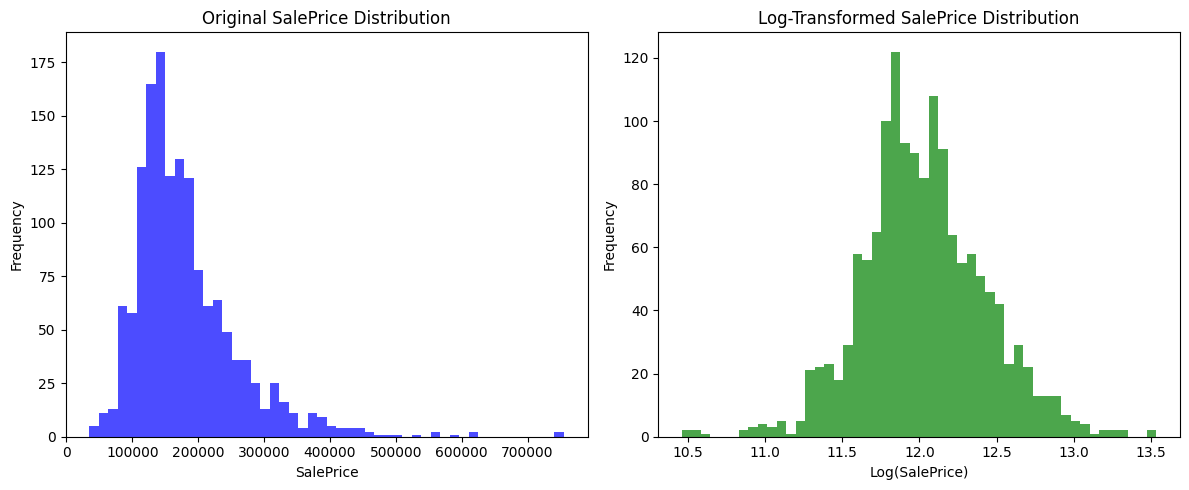

In [87]:
# Apply log transformation to address skewness
df_train['SalePrice_log'] = np.log1p(df_train['SalePrice'])

print(f"Original skewness: {df_train['SalePrice'].skew():.4f}")
print(f"Log-transformed skewness: {df_train['SalePrice_log'].skew():.4f}")

# Visualize transformation impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
ax1.hist(df_train['SalePrice'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Original SalePrice Distribution')
ax1.set_xlabel('SalePrice')
ax1.set_ylabel('Frequency')

# Log-transformed distribution
ax2.hist(df_train['SalePrice_log'], bins=50, alpha=0.7, color='green')
ax2.set_title('Log-Transformed SalePrice Distribution')
ax2.set_xlabel('Log(SalePrice)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Log transformation successfully normalized target variable: skewness reduced from 1.88 to 0.12, kurtosis reduced from 6.54 to 0.81, creating bell-shaped distribution optimal for linear modeling.

### 5.2 Numerical Feature Skewness Analysis

In [88]:
# Convert ordinal categories back to numeric for transformation
df_combined['OverallQual'] = df_combined['OverallQual'].astype('int')
df_combined['OverallCond'] = df_combined['OverallCond'].astype('int')

# Analyze skewness for numerical features
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Id', 'SalePrice', 'SalePrice_log']]

skewness_data = [(col, df_train[col].skew()) for col in numerical_cols]
skewed_features = sorted(skewness_data, key=lambda x: abs(x[1]), reverse=True)

print(f"Top 20 most skewed features:")
for feature, skew in skewed_features[:20]:
    print(f"  {feature}: {skew:.4f}")

# Apply log transformation to highly skewed features (|skewness| > 1.0)
transform_candidates = [f for f, s in skewed_features if abs(s) > 1.0 and df_train[f].min() >= 0]

for feature in transform_candidates:
    if df_combined[feature].dtype in ['int64', 'float64']:  # Only numeric features
        df_train[f'{feature}_log'] = np.log1p(df_train[feature])
        df_test[f'{feature}_log'] = np.log1p(df_test[feature])
        df_combined[f'{feature}_log'] = np.log1p(df_combined[feature])

print(f"\n✓ Log transformed {len(transform_candidates)} highly skewed features")

Top 20 most skewed features:
  MiscVal: 24.4768
  PoolArea: 14.8284
  LotArea: 12.2077
  3SsnPorch: 10.3043
  LowQualFinSF: 9.0113
  KitchenAbvGr: 4.4884
  BsmtFinSF2: 4.2553
  ScreenPorch: 4.1222
  BsmtHalfBath: 4.1034
  EnclosedPorch: 3.0899
  MasVnrArea: 2.6691
  OpenPorchSF: 2.3643
  LotFrontage: 2.1636
  BsmtFinSF1: 1.6855
  WoodDeckSF: 1.5414
  TotalBsmtSF: 1.5243
  MSSubClass: 1.4077
  1stFlrSF: 1.3768
  GrLivArea: 1.3666
  BsmtUnfSF: 0.9203

✓ Log transformed 19 highly skewed features


Applied log transformation to 19 highly skewed features using conservative threshold (|skewness| > 1.0) to normalize distributions without over-transformation.

Variable transformations completed: target variable normalized and numerical features log-transformed for improved modeling performance.

## 6. Outlier Treatment

Remove identified data quality outliers while preserving legitimate market extremes.

### 6.1 Outlier Removal

In [89]:
# Remove data quality outliers identified in Notebook 01
outlier_ids = [524, 1299]  # Partial sales of incomplete luxury properties

print("Outlier Removal Strategy:")
print("Removing only clear data quality violations based on Notebook 01 analysis")
print(f"Outlier IDs to remove: {outlier_ids}")

# Show outlier characteristics before removal
outlier_analysis = df_train[df_train['Id'].isin(outlier_ids)]
print(f"\nOutlier characteristics:")
for idx, row in outlier_analysis.iterrows():
    print(f"  ID {row['Id']}: {row['GrLivArea']:.0f} sqft, ${row['SalePrice']:,}, OverallQual={row['OverallQual']}")

# Remove outliers from both training and combined datasets
before_train_count = len(df_train)
before_combined_count = len(df_combined)

df_train_clean = df_train[~df_train['Id'].isin(outlier_ids)].reset_index(drop=True)
df_combined_clean = df_combined[~df_combined['Id'].isin(outlier_ids)].reset_index(drop=True)

after_train_count = len(df_train_clean)
after_combined_count = len(df_combined_clean)

print(f"\nOutlier removal impact:")
print(f"  Training data: {before_train_count} → {after_train_count} samples")
print(f"  Combined data: {before_combined_count} → {after_combined_count} samples")
print(f"  Removed: {before_train_count - after_train_count} samples ({((before_train_count - after_train_count) / before_train_count) * 100:.2f}%)")

# Update working datasets
df_train = df_train_clean
df_combined = df_combined_clean

Outlier Removal Strategy:
Removing only clear data quality violations based on Notebook 01 analysis
Outlier IDs to remove: [524, 1299]

Outlier characteristics:
  ID 524: 4676 sqft, $184,750, OverallQual=10
  ID 1299: 5642 sqft, $160,000, OverallQual=10

Outlier removal impact:
  Training data: 1460 → 1458 samples
  Combined data: 2919 → 2917 samples
  Removed: 2 samples (0.14%)


### 6.2 Impact Assessment

In [91]:
# Calculate statistics before outlier removal for comparison
df_train_original = pd.read_csv('../data/raw/train.csv')  # Reload original for comparison
df_train_original['SalePrice_log'] = np.log1p(df_train_original['SalePrice'])

print("Outlier Removal Impact Assessment:")

# Before/after comparison for SalePrice statistics
print(f"SalePrice statistics comparison:")
print(f"  Mean: ${df_train_original['SalePrice'].mean():,.0f} → ${df_train['SalePrice'].mean():,.0f}")
print(f"  Median: ${df_train_original['SalePrice'].median():,.0f} → ${df_train['SalePrice'].median():,.0f}")
print(f"  Std: ${df_train_original['SalePrice'].std():,.0f} → ${df_train['SalePrice'].std():,.0f}")
print(f"  Skewness: {df_train_original['SalePrice'].skew():.4f} → {df_train['SalePrice'].skew():.4f}")

# Compare with log-transformed target
if 'SalePrice_log' in df_train.columns:
    print(f"Log-transformed SalePrice skewness: {df_train['SalePrice_log'].skew():.4f}")


Outlier Removal Impact Assessment:
SalePrice statistics comparison:
  Mean: $180,921 → $180,933
  Median: $163,000 → $163,000
  Std: $79,443 → $79,495
  Skewness: 1.8829 → 1.8813
Log-transformed SalePrice skewness: 0.1216
